## Exceptional Work
### Overview
For our exceptional work we have decided to revisit our analyses from Lab 2, attempt to recreate them using clustering instead of classification, and compare the results between the two. To recap, in Lab 2 we used player season-level performance statistics along with classification algorithms in an attempt to categorize players by position using attributes other than position.

In this analysis we will use clustering to group players based on stats. To assess clustering accuracy and purity. We will assing a position to each final cluster group based on the majority position in that group. So for example, if a cluster had seven catchers and three outfields we would assign the predicted position to every player in that group as catcher.

### Data Prep
For this assessment we excluded pitchers and designated hitters since most of our predictor fields will be based on fielding (e.g., number of put outs by a player). We're selecting fielding statistics because these were predictive variables in our classification models in Lab 2.

Also, to account for the fact that players will have played different numbers of games each year, we calculated a "per game played on the field" value for each of the fielding stats per year. Lastly, we excluded any years where a player played no games in a given year.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
plt.style.use("ggplot")

# LOAD DATA
player = pd.read_pickle("./analysisdata/player.pkl")

# Remove DH Since this will be an assessment using defensive stats
player = player.loc[player['Primary'] != "DH"]
# Player must have played games in a given year
player = player.loc[player['G_y'] > 0]

# Calculate per game stats
player = player.assign(ApG = player.A / player.G_y)
player = player.assign(POpG = player.PO / player.G_y)
player = player.assign(DPpG = player.DP / player.G_y)

# Sort By Position
player = player.sort_values(by=['Primary'])

# Analysis Data
X1 = player[['POpG', 'ApG', "DPpG"]]

### KMeans Clustering

Using only three fielding statistics (outs played, assists, and double plays per game) and 20 cluster groups, kmeans was able to produce accuracy of around 85%.

In [2]:
bestAcc = 0
bestN = 0
for i in range(6,31):
    cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
    cls.fit(X1)
    newfeature_kmeans = cls.labels_ 
    plotDat = player[["Primary"]]
    plotDat = plotDat.assign(KMeans_Clust = newfeature_kmeans)
    clustGroupMap = plotDat.groupby(['Primary']).agg(lambda x:x.value_counts().index[0])
    clustGroupMap.reset_index(level=0, inplace=True)
    clustGroupMap = clustGroupMap.rename(index=str, columns={"Primary":"Clust_Pred"})
    AccData = plotDat.merge(clustGroupMap, on="KMeans_Clust")
    newAcc = np.mean(AccData.Primary == AccData.Clust_Pred)
    if newAcc > bestAcc:
            bestN = i
    print(i, " Cluster Accuracy: ",np.mean(AccData.Primary == AccData.Clust_Pred))

6  Cluster Accuracy:  0.6406267179769104
7  Cluster Accuracy:  0.674322698894553
8  Cluster Accuracy:  0.6913536498936924
9  Cluster Accuracy:  0.687715269804822
10  Cluster Accuracy:  0.6726445026900262
11  Cluster Accuracy:  0.7254759011745646
12  Cluster Accuracy:  0.6647250698974837
13  Cluster Accuracy:  0.7390323163025817
14  Cluster Accuracy:  0.7514113295697878
15  Cluster Accuracy:  0.7624455033965325
16  Cluster Accuracy:  0.7591892459567318
17  Cluster Accuracy:  0.8419936373276776
18  Cluster Accuracy:  0.8386406544996854
19  Cluster Accuracy:  0.841350540998566
20  Cluster Accuracy:  0.8531863404140898
21  Cluster Accuracy:  0.8521306627234844
22  Cluster Accuracy:  0.8405943450663589
23  Cluster Accuracy:  0.8525902007581075
24  Cluster Accuracy:  0.8650333429979704
25  Cluster Accuracy:  0.8713765246317123
26  Cluster Accuracy:  0.8608985024958402
27  Cluster Accuracy:  0.8725611644471972
28  Cluster Accuracy:  0.8462815405046481
29  Cluster Accuracy:  0.8671861165220471

We produced the heatmap below help visualize the purity clusters once they were assigned a position. The plot shows that clusters for outfielders are very pure with very few misclassifications. In contrast, the clusters are less accurate when trying to differentiate between shortstops and second basemen. This is not surprising since the fielding statistics will be comparable between those two positions.

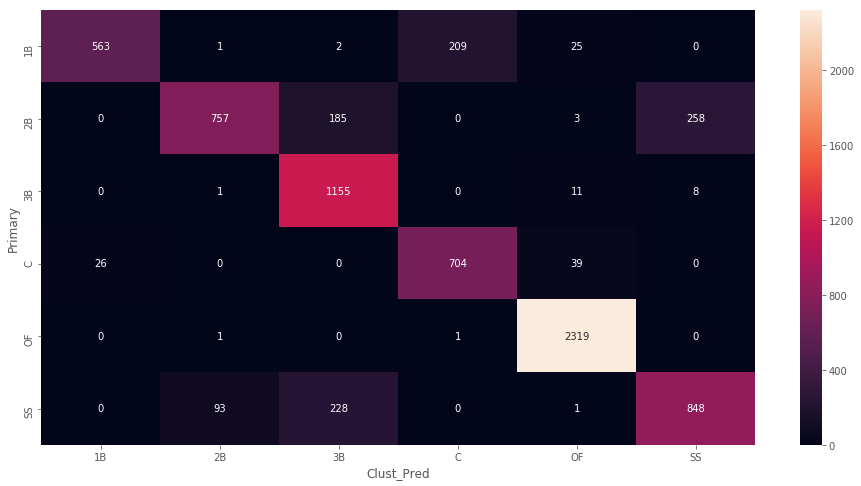

In [3]:
cls = KMeans(n_clusters=20, init='k-means++',random_state=1)
cls.fit(X1)
newfeature_kmeans = cls.labels_ 

fig, ax = pyplot.subplots(figsize=(16, 8))
plotDat = player[["Primary"]]
plotDat = plotDat.assign(KMeans_Clust = newfeature_kmeans)
clustGroupMap = plotDat.groupby(['Primary']).agg(lambda x:x.value_counts().index[0])
clustGroupMap.reset_index(level=0, inplace=True)
clustGroupMap = clustGroupMap.rename(index=str, columns={"Primary":"Clust_Pred"})
AccData = plotDat.merge(clustGroupMap, on="KMeans_Clust")
sns.heatmap(pd.crosstab(AccData.Primary, AccData.Clust_Pred), annot=True, fmt=".0f")

### Hierarchical Clustering

Hierarchical Clustering was able to come up with similar accuracy to kmean clustering (around 85%) using ~20 clusters and the Ward's link method. The other link options did not produce as good of results as Ward's method. Again using only three fielding statistics (outs played, assists, and double plays per game) and 20 cluster groups, kmeans was able to produce accuracy of around 85%.

Since both Kmeans and hierarchical clustering produced similar results. We would recommend using kmeans in the future since the computational power and time necessary to run kmean is significantly less than HAC clustering.

In [5]:
bestAcc = 0
bestN = 0
bestLink = None
for i in range(6,31):
    for link in ['ward', 'complete', 'average']:
        cls = AgglomerativeClustering(n_clusters=i, linkage=link, compute_full_tree = False)
        cls.fit(X1)
        clustLab = cls.labels_ 
        plotDat = player[["Primary"]]
        plotDat = plotDat.assign(Clust = clustLab)
        clustGroupMap = plotDat.groupby(['Primary']).agg(lambda x:x.value_counts().index[0])
        clustGroupMap.reset_index(level=0, inplace=True)
        clustGroupMap = clustGroupMap.rename(index=str, columns={"Primary":"Clust_Pred"})
        AccData = plotDat.merge(clustGroupMap, on="Clust")
        newAcc = np.mean(AccData.Primary == AccData.Clust_Pred)
        if newAcc > bestAcc:
                bestN = i
                bestLink = link
        print(i, " Cluster, " ,link, " Link Accuracy: ",np.mean(AccData.Primary == AccData.Clust_Pred))


6  Cluster,  ward  Link Accuracy:  0.5029122468659595
6  Cluster,  complete  Link Accuracy:  0.4432451143909117
6  Cluster,  average  Link Accuracy:  0.27403832047181714
7  Cluster,  ward  Link Accuracy:  0.669919534326314
7  Cluster,  complete  Link Accuracy:  0.44323439614743004
7  Cluster,  average  Link Accuracy:  0.2766135792120704
8  Cluster,  ward  Link Accuracy:  0.6767415446744068
8  Cluster,  complete  Link Accuracy:  0.44323439614743004
8  Cluster,  average  Link Accuracy:  0.2766135792120704
9  Cluster,  ward  Link Accuracy:  0.6808862433862434
9  Cluster,  complete  Link Accuracy:  0.4430183668953308
9  Cluster,  average  Link Accuracy:  0.526501546053659
10  Cluster,  ward  Link Accuracy:  0.6808862433862434
10  Cluster,  complete  Link Accuracy:  0.4421486293772778
10  Cluster,  average  Link Accuracy:  0.5265558610347413
11  Cluster,  ward  Link Accuracy:  0.640600624024961
11  Cluster,  complete  Link Accuracy:  0.4411404244339805
11  Cluster,  average  Link Accuracy: 

Again, just as with KMean, the outfield clusters were the most pure and easy to categorize, while the center infielders were the least. Also of note, this model seems to find some similarities between catchers and first baseman.

In [ ]:
cls = AgglomerativeClustering(n_clusters=20, linkage="ward")
cls.fit(X1)
newfeature_hac = cls.labels_ 

from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(16, 8))
plotDat = player[["Primary"]]
plotDat = plotDat.assign(HAC_Clust = newfeature_hac)
clustGroupMap = plotDat.groupby(['Primary']).agg(lambda x:x.value_counts().index[0])
clustGroupMap.reset_index(level=0, inplace=True)
clustGroupMap = clustGroupMap.rename(index=str, columns={"Primary":"Clust_Pred"})
AccData = plotDat.merge(clustGroupMap, on="HAC_Clust")
sns.heatmap(pd.crosstab(AccData.Primary, AccData.Clust_Pred), annot=True, fmt=".0f")

### DBSCAN Clustering

We attempted several different iterations of DBSCAN clustering from position categorization, however none produced any results worth including. The majority of the players were grouped into a single large cluster along with several smaller clusters with very few players.

### Comparison to Classification
The accuracy of the clustering models was on par with the best accuracies produced with Random Forest (RF) models in Lab 2. The RF models are likely more practical given that clustering is unsupervised and requires known labels to assign cluster labels making predicting unknown player positions harder than with the RF model.